## 1. Setup and Imports

In [1]:
import os
from os import path
import glob
import pandas as pd
import numpy as np
import wget
# from github import Github # Not used in the final flow, can be removed if not needed elsewhere
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# Signal Processing / Feature Extraction related
from scipy import signal
from scipy.ndimage import label as sci_label
from scipy.stats import zscore, kurtosis, skew
from scipy.interpolate import interp1d
from numpy import trapz
import statistics

# Scikit-learn specific
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# Balancing
from imblearn.over_sampling import SMOTE

# Other ML Models
from xgboost import XGBClassifier

# Tensorflow (Optional: only if initial DL model part is kept/run)
# import tensorflow as tf
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ModelCheckpoint

# Settings
warnings.filterwarnings('ignore') # Ignore warnings for cleaner output
pd.set_option('display.max_columns', None) # Show all columns in DataFrames

print("Libraries imported successfully.")

Libraries imported successfully.


## 2. Configuration and Data Loading

In [2]:
print("\n--- Section 2: Configuration and Data Loading ---")
# --- Configuration: PLEASE UPDATE THESE PATHS ---
base_data_path = 'C:\\\\Users\\\\ferri\\\\Downloads\\\\PoliTO\\\\Tesi\\\\DSs\\\\Emotion-Stress\\\\ECG_GSR_Emotions'
raw_multimodal_ecg_path = os.path.join(base_data_path, 'Raw Data', 'Multimodal', 'ECG')
raw_singlemodal_ecg_path = os.path.join(base_data_path, 'Raw Data', 'Single Modal', 'ECG')
stimulus_desc_file_path = os.path.join(base_data_path, 'Stimulus_Description.xlsx')
self_annotation_multimodal_path = os.path.join(base_data_path, 'Self-Annotation Labels', 'Self-annotation Multimodal_Use.xlsx')
self_annotation_singlemodal_path = os.path.join(base_data_path, 'Self-Annotation Labels', 'Self-annotation Single Modal_Use.xlsx')
output_dir = os.path.join(base_data_path, 'Processed_Output') # Define an output directory
# --

# Create output directories if they don't exist
os.makedirs(raw_multimodal_ecg_path, exist_ok=True)
os.makedirs(raw_singlemodal_ecg_path, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

# Optional: Clean up previous CSV/XLSX files in the *current* working directory (be careful)
# print("Cleaning up old files...")
# for f in glob.glob('*.csv'): os.remove(f)
# for f in glob.glob('*.xlsx'): os.remove(f)

print(f"Base data path: {base_data_path}")
print(f"Multimodal ECG path: {raw_multimodal_ecg_path}")
print(f"Singlemodal ECG path: {raw_singlemodal_ecg_path}")
print(f"Output directory: {output_dir}")

# Load and combine annotation files
try:
    stimulus_desc_file = pd.read_excel(stimulus_desc_file_path)
    stimulus_desc_file.to_csv('Stimulus_Description.csv', index = None, header=True)
    stimulus_desc = pd.read_csv('Stimulus_Description.csv')

    self_annotation_multimodal_file = pd.read_excel(self_annotation_multimodal_path)
    self_annotation_multimodal_file.to_csv('Self-annotation Multimodal_Use.csv', index = None, header=True)
    self_annotation_multimodal = pd.read_csv('Self-annotation Multimodal_Use.csv')
    self_annotation_multimodal['annotation'] = 'M'
    self_annotation_multimodal.rename(columns = {'V_Label':'Valence', 'A_Label':'Arousal', 'Four_Labels':'Four_Label'}, inplace = True)

    self_annotation_singlemodal_file = pd.read_excel(self_annotation_singlemodal_path)
    self_annotation_singlemodal_file.to_csv('Self-annotation Single Modal_Use.csv', index = None, header=True)
    self_annotation_singlemodal = pd.read_csv('Self-annotation Single Modal_Use.csv')
    self_annotation_singlemodal['annotation'] = 'S'
    self_annotation_singlemodal.rename(columns = {'Male':'Gender', 'Session Id':'Session ID', 'Video Id':'Video ID'}, inplace = True)

    # Combine annotations
    self_annotation_frames = [self_annotation_multimodal, self_annotation_singlemodal]
    merged_dataframe = pd.concat(self_annotation_frames, ignore_index=True)
    print("Annotations loaded and merged successfully.")
    # merged_dataframe.info()

except FileNotFoundError as e:
    print(f"Error loading annotation files: {e}")
    print("Please ensure the paths in the 'Configuration' section are correct.")
    # Stop execution if files aren't found
    raise


--- Section 2: Configuration and Data Loading ---
Base data path: C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\ECG_GSR_Emotions
Multimodal ECG path: C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\ECG_GSR_Emotions\Raw Data\Multimodal\ECG
Singlemodal ECG path: C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\ECG_GSR_Emotions\Raw Data\Single Modal\ECG
Output directory: C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\ECG_GSR_Emotions\Processed_Output
Annotations loaded and merged successfully.


## 3. Load Raw ECG Data and Merge with Annotations

In [3]:
print("\n--- Section 3: Load Raw ECG Data ---")
arr_shape = 1000 # Define the length to process for each ECG signal
raw_data_arr = []

def form_data(data_array, annotation_type, data_path, annotations_df, stimulus_df):
    print(f"Processing files from: {data_path} for annotation type: {annotation_type}")
    files_processed = 0
    files_skipped_load_error = 0
    files_skipped_no_match = 0

    if not os.path.exists(data_path):
        print(f"Warning: Directory not found - {data_path}. Skipping.")
        return data_array, 0, 0, 0

    for filename in os.listdir(data_path):
        if not filename.endswith('.dat'): # Process only .dat files
            continue

        file_path = os.path.join(data_path, filename)
        try:
            data = np.loadtxt(file_path, delimiter=',')
            if len(data) < arr_shape:
                # Optional: Pad shorter signals if needed, or skip
                # print(f"Warning: Signal {filename} shorter than {arr_shape}, skipping.")
                # continue
                # Padding example (use with caution):
                pad_width = arr_shape - len(data)
                data = np.pad(data, (0, pad_width), 'constant', constant_values=0)
            else:
                data = data[0:arr_shape] # Truncate longer signals

            # Extract IDs from filename (handle potential errors)
            try:
                base_name = filename.split('ECGdata_')[1].split('.dat')[0].lower()
                s_part = base_name.split('s')[1]
                s = int(s_part.split('p')[0])
                p_part = s_part.split('p')[1]
                p = int(p_part.split('v')[0])
                v = int(p_part.split('v')[1])
            except (IndexError, ValueError) as e:
                # print(f"Warning: Could not parse IDs from filename {filename}. Error: {e}. Skipping.")
                files_skipped_load_error += 1
                continue

            # Find matching annotation row
            data_row = annotations_df.loc[
                (annotations_df['Session ID'] == s) &
                (annotations_df['Participant Id'] == p) &
                (annotations_df['Video ID'] == v) &
                (annotations_df['annotation'] == annotation_type)
            ]

            # Find matching stimulus row
            stim_row = stimulus_df.loc[
                (stimulus_df['Session ID'] == s) &
                (stimulus_df['Video ID'] == v)
            ]

            if not data_row.empty and not stim_row.empty:
                # Add data and annotations to the list
                for index, row in data_row.iterrows(): # Should typically be one row, but loop just in case
                    data_array.append([
                        data,
                        row['Participant Id'], row['Session ID'], row['Video ID'],
                        row['Name'], row['Age'], row['Gender'], row['Valence level'],
                        row['Arousal level'], row['Dominance level'], row['Happy'],
                        row['Sad'], row['Fear'], row['Anger'], row['Neutral'],
                        row['Disgust'], row['Surprised'], row['Familiarity Score'],
                        row['Emotion'], row['Valence'], row['Arousal'], row['Four_Label'],
                        row['annotation'],
                        stim_row['Target Emotion'].iloc[0] # Use iloc[0] assuming one match
                    ])
                files_processed += 1
            else:
                # print(f"Warning: No matching annotation/stimulus found for S{s}P{p}V{v} ({annotation_type}). Skipping.")
                files_skipped_no_match += 1

        except Exception as e:
            print(f"Error loading or processing file {filename}: {e}. Skipping.")
            files_skipped_load_error += 1
            continue

    print(f"Finished processing {annotation_type}. Processed: {files_processed}, Skipped (Load Error): {files_skipped_load_error}, Skipped (No Match): {files_skipped_no_match}")
    return data_array, files_processed, files_skipped_load_error, files_skipped_no_match

# Process both multimodal and single modal data
total_processed = 0
total_skipped_load = 0
total_skipped_match = 0

raw_data_arr, processed, skipped_load, skipped_match = form_data(
    raw_data_arr, 'M', raw_multimodal_ecg_path, merged_dataframe, stimulus_desc
)
total_processed += processed
total_skipped_load += skipped_load
total_skipped_match += skipped_match

raw_data_arr, processed, skipped_load, skipped_match = form_data(
    raw_data_arr, 'S', raw_singlemodal_ecg_path, merged_dataframe, stimulus_desc
)
total_processed += processed
total_skipped_load += skipped_load
total_skipped_match += skipped_match

# Define columns for the DataFrame
cols = [
    'Raw Data', 'Participant Id', 'Session ID', 'Video ID', 'Name', 'Age',
    'Gender', 'Valence level', 'Arousal level', 'Dominance level', 'Happy',
    'Sad', 'Fear', 'Anger', 'Neutral', 'Disgust', 'Surprised',
    'Familiarity Score', 'Emotion', 'Valence', 'Arousal', 'Four_Label',
    'annotation', 'Target Emotion'
]

if raw_data_arr: # Check if any data was loaded
    raw_dataframe = pd.DataFrame(raw_data_arr, columns=cols)
    raw_dataframe.rename(columns={'Participant Id': 'Participant ID', 'annotation': 'Modal', 'Four_Label': 'Four label'}, inplace=True)
    raw_dataframe['Familiarity Score'] = raw_dataframe['Familiarity Score'].fillna('Never watched')
    raw_dataframe = raw_dataframe.replace(np.nan, '', regex=True) # Replace NaN with empty string cautiously

    print(f"\nTotal files processed successfully: {total_processed}")
    print(f"Total files skipped (load/parse error): {total_skipped_load}")
    print(f"Total files skipped (no annotation/stimulus match): {total_skipped_match}")
    print("Raw DataFrame created:")
    print(raw_dataframe.info())
    # print(raw_dataframe.head())
else:
    print("\nError: No data was loaded successfully. Cannot create DataFrame.")
    print("Please check file paths, file formats, and filenames.")
    # Stop execution if no data
    raise ValueError("No data loaded into raw_data_arr")


--- Section 3: Load Raw ECG Data ---
Processing files from: C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\ECG_GSR_Emotions\Raw Data\Multimodal\ECG for annotation type: M
Finished processing M. Processed: 247, Skipped (Load Error): 0, Skipped (No Match): 5
Processing files from: C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\ECG_GSR_Emotions\Raw Data\Single Modal\ECG for annotation type: S
Finished processing S. Processed: 147, Skipped (Load Error): 0, Skipped (No Match): 7

Total files processed successfully: 394
Total files skipped (load/parse error): 0
Total files skipped (no annotation/stimulus match): 12
Raw DataFrame created:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Raw Data           406 non-null    object
 1   Participant ID     406 non-null    int64 
 2   Session ID         406 non-

## 4. Feature Extraction (HRV Features)

In [4]:
print("\n--- Section 4: Feature Extraction ---")

## Reference: https://github.com/chandanacharya1/ECG-Feature-extraction-using-Python/blob/master/features.py
## Adapted functions for feature extraction

def detect_peaks(ecg_signal, sfreq=100, threshold=0.6, qrs_filter=None):
    '''
    Peak detection algorithm using cross-correlation and threshold.
    sfreq: Sampling frequency in Hz.
    '''
    if qrs_filter is None:
        # Create default QRS filter (simple sine wave segment)
        # Adjust filter length based on typical QRS duration (~0.1s)
        filter_len = int(0.1 * sfreq)
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, filter_len)
        qrs_filter = np.sin(t)

    # Normalize data
    if np.std(ecg_signal) != 0:
        ecg_signal_norm = (ecg_signal - np.mean(ecg_signal)) / np.std(ecg_signal)
    else:
        ecg_signal_norm = ecg_signal # Avoid division by zero if signal is flat

    # Calculate cross-correlation
    similarity = np.correlate(ecg_signal_norm, qrs_filter, mode="same")
    if np.max(similarity) != 0:
        similarity = similarity / np.max(similarity)
    else: # Avoid division by zero if similarity is flat
        similarity = similarity # Keep it as is (likely all zeros)

    # Find indices where similarity exceeds threshold
    # Need to handle the case where ecg_signal is a Series or ndarray
    if isinstance(ecg_signal, pd.Series):
        indices = ecg_signal.index[similarity > threshold].to_numpy()
    else: # Assuming ndarray
        indices = np.where(similarity > threshold)[0]

    return indices, similarity

def group_peaks(p, sfreq=100, min_rr_ms=200): # min_rr_ms: minimum physiological RR interval in ms
    '''
    Group close peaks based on physiological constraints.
    '''
    # Calculate the minimum distance between peaks in samples
    min_dist_samples = int((min_rr_ms / 1000.0) * sfreq)

    if len(p) == 0:
        return np.empty(0)

    # Sort peaks first
    p = np.sort(p)

    grouped_peaks = [p[0]] # Start with the first peak

    for i in range(1, len(p)):
        # If the current peak is sufficiently far from the last *accepted* peak
        if (p[i] - grouped_peaks[-1]) >= min_dist_samples:
            grouped_peaks.append(p[i])
        else:
            # Optional: Refine by choosing the peak with max similarity within a small window (more complex)
            # For simplicity, we currently just skip peaks that are too close
            pass

    return np.array(grouped_peaks)

def calculate_rr_intervals(signal_data, sfreq=100):
    '''Calculates RR intervals in milliseconds.'''
    peaks_indices, _ = detect_peaks(signal_data, sfreq=sfreq, threshold=0.6)
    if len(peaks_indices) < 2:
        return np.empty(0) # Not enough peaks to calculate intervals

    grouped_peak_indices = group_peaks(peaks_indices, sfreq=sfreq)

    if len(grouped_peak_indices) < 2:
        return np.empty(0) # Not enough grouped peaks

    # Calculate differences between consecutive peak indices
    rr_intervals_samples = np.diff(grouped_peak_indices)

    # Convert samples to milliseconds
    rr_intervals_ms = (rr_intervals_samples / sfreq) * 1000

    # Basic outlier removal (e.g., remove intervals outside 300-2000 ms range)
    rr_intervals_ms = rr_intervals_ms[(rr_intervals_ms > 300) & (rr_intervals_ms < 2000)]

    return rr_intervals_ms

# --- Feature Calculation Functions ---
# Use RR intervals (in ms) as input 'nni_list'

def calc_mean_rr(nni_list):
    return np.mean(nni_list) if len(nni_list) > 0 else 0

def calc_median_rr(nni_list):
    return np.median(nni_list) if len(nni_list) > 0 else 0

def calc_sdrr(nni_list):
    return np.std(nni_list, ddof=1) if len(nni_list) > 1 else 0

def calc_rmssd(nni_list):
    if len(nni_list) < 2:
        return 0
    diff_nni = np.diff(nni_list)
    return np.sqrt(np.mean(diff_nni ** 2))

def calc_sdrr_rmssd_ratio(sdrr, rmssd):
    return sdrr / rmssd if rmssd != 0 else 0

def calc_hr(nni_list):
    # Calculate instantaneous HR for each interval, then average
    if len(nni_list) == 0:
        return 0
    heart_rates = 60000 / nni_list
    return np.mean(heart_rates)

def calc_NNx(nni_list, threshold_ms=50):
    if len(nni_list) < 2:
        return 0
    diff_nni = np.diff(nni_list)
    return np.sum(np.abs(diff_nni) > threshold_ms)

def calc_pNNx(nni_list, threshold_ms=50):
    if len(nni_list) < 2:
        return 0
    nnx = calc_NNx(nni_list, threshold_ms)
    return (nnx / len(nni_list)) * 100

# Non-linear domain features (Poincaré plot)
def calc_sd1(nni_list):
    if len(nni_list) < 2:
        return 0
    diff_nni = np.diff(nni_list)
    # Variance of the differences
    var_diff = np.var(diff_nni, ddof=1)
    return np.sqrt(var_diff * 0.5)

def calc_sd2(nni_list):
    if len(nni_list) < 2:
        return 0
    diff_nni = np.diff(nni_list)
    # Variance of the NNI intervals themselves and the differences
    var_nni = np.var(nni_list, ddof=1)
    var_diff = np.var(diff_nni, ddof=1)
    # Ensure the value under the square root is non-negative
    sd2_squared = 2 * var_nni - 0.5 * var_diff
    return np.sqrt(max(0, sd2_squared)) # Use max(0, ...) to handle potential floating point inaccuracies

def calc_sd1_sd2_ratio(sd1, sd2):
    return sd1 / sd2 if sd2 != 0 else 0

# Other statistical features (applied to NNI list)
def calc_skewness(nni_list):
    return skew(nni_list) if len(nni_list) > 0 else 0

def calc_kurtosis_val(nni_list):
    return kurtosis(nni_list) if len(nni_list) > 0 else 0

print("Feature extraction functions defined.")

# Apply feature extraction to the raw ECG data
start_time = datetime.now()
print(f"Starting feature extraction at: {start_time}")

# Assume sampling frequency is constant, e.g., 100 Hz (adjust if needed)
SAMPLING_FREQUENCY = 100

extracted_features_list = []

for index, row in raw_dataframe.iterrows():
    ecg_signal = row['Raw Data']

    # Calculate RR intervals first
    rr_intervals = calculate_rr_intervals(ecg_signal, sfreq=SAMPLING_FREQUENCY)

    # Calculate features based on RR intervals
    if len(rr_intervals) > 1: # Need at least 2 intervals for most features
        meanrr = calc_mean_rr(rr_intervals)
        medianrr = calc_median_rr(rr_intervals)
        sdrr = calc_sdrr(rr_intervals)
        rmssd = calc_rmssd(rr_intervals)
        sdrr_rmssd = calc_sdrr_rmssd_ratio(sdrr, rmssd)
        hr = calc_hr(rr_intervals)
        nn50 = calc_NNx(rr_intervals, threshold_ms=50)
        pnn50 = calc_pNNx(rr_intervals, threshold_ms=50)
        sd1 = calc_sd1(rr_intervals)
        sd2 = calc_sd2(rr_intervals)
        sd1_sd2_ratio = calc_sd1_sd2_ratio(sd1, sd2)
        skewness = calc_skewness(rr_intervals)
        kurt = calc_kurtosis_val(rr_intervals)
    else:
        # Assign default values if not enough RR intervals found
        meanrr, medianrr, sdrr, rmssd, sdrr_rmssd, hr, nn50, pnn50, sd1, sd2, sd1_sd2_ratio, skewness, kurt = [0] * 13
        # print(f"Warning: Not enough RR intervals for index {index}, assigning zeros.")

    # Append features along with identifiers and target
    extracted_features_list.append([
        row['Participant ID'], row['Session ID'], row['Video ID'], # Identifiers
        meanrr, medianrr, sdrr, rmssd, sdrr_rmssd, hr, nn50, pnn50,
        sd1, sd2, sd1_sd2_ratio, skewness, kurt,
        row['Emotion'] # Target variable
    ])

# Create DataFrame from the list of features
feature_columns = [
    'Participant ID', 'Session ID', 'Video ID', # Identifiers
    'meanrr', 'medianrr', 'sdrr', 'rmssd', 'sdrr_rmssd', 'hr', 'nn50', 'pnn50',
    'sd1', 'sd2', 'sd1_sd2_ratio', 'skewness', 'kurtosis',
    'emotion' # Target
]
features_df = pd.DataFrame(extracted_features_list, columns=feature_columns)

# Handle potential NaN/inf values that might arise from calculations (e.g., division by zero)
features_df.replace([np.inf, -np.inf], np.nan, inplace=True)
features_df.fillna(0, inplace=True) # Replace NaN with 0 (consider other strategies if needed)

end_time = datetime.now()
print(f"Feature extraction completed at: {end_time}")
print(f"Duration: {end_time - start_time}")
print("Extracted Features DataFrame:")
print(features_df.info())
# print(features_df.head())


--- Section 4: Feature Extraction ---
Feature extraction functions defined.
Starting feature extraction at: 2025-04-25 14:49:47.637502
Feature extraction completed at: 2025-04-25 14:49:47.845110
Duration: 0:00:00.207608
Extracted Features DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Participant ID  406 non-null    int64  
 1   Session ID      406 non-null    int64  
 2   Video ID        406 non-null    int64  
 3   meanrr          406 non-null    float64
 4   medianrr        406 non-null    float64
 5   sdrr            406 non-null    float64
 6   rmssd           406 non-null    float64
 7   sdrr_rmssd      406 non-null    float64
 8   hr              406 non-null    float64
 9   nn50            406 non-null    int64  
 10  pnn50           406 non-null    float64
 11  sd1             406 non-null    float64
 12  sd2      

## 5. Data Splitting (Train/Test)

In [5]:
print("\n--- Section 5: Data Splitting ---")
# Split the data *before* feature selection and balancing to prevent data leakage.

# Define features (X) and target (y)
X = features_df.drop(['Participant ID', 'Session ID', 'Video ID', 'emotion'], axis=1) # Drop identifiers and target
y = features_df['emotion']

# Encode the target variable (emotion labels)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Emotion labels encoded:", dict(zip(le.classes_, le.transform(le.classes_))))

# Split into training and testing sets (e.g., 70% train, 30% test)
# Use stratify=y_encoded to maintain class proportions in train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

print(f"Original dataset shape: {X.shape}")
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

# Check class distribution in train and test sets
print("\nTraining set class distribution:")
print(pd.Series(y_train).value_counts(normalize=True))
print("\nTesting set class distribution:")
print(pd.Series(y_test).value_counts(normalize=True))


--- Section 5: Data Splitting ---
Emotion labels encoded: {'Anger': np.int64(0), 'Disgust': np.int64(1), 'Fear': np.int64(2), 'Happy': np.int64(3), 'Mixed': np.int64(4), 'Neutral': np.int64(5), 'Sad': np.int64(6), 'Surprise': np.int64(7)}
Original dataset shape: (406, 13)
Training set shape: (284, 13), (284,)
Testing set shape: (122, 13), (122,)

Training set class distribution:
3    0.295775
4    0.214789
6    0.112676
5    0.091549
1    0.084507
2    0.084507
0    0.070423
7    0.045775
Name: proportion, dtype: float64

Testing set class distribution:
3    0.295082
4    0.221311
6    0.114754
2    0.090164
5    0.090164
1    0.081967
0    0.065574
7    0.040984
Name: proportion, dtype: float64


## 6. Feature Scaling

In [6]:
print("\n--- Section 6: Feature Scaling ---")
# Scale features after splitting.

scaler = StandardScaler()

# Fit scaler ONLY on training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform both training and testing data using the fitted scaler
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames (optional, but maintains column names)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Features scaled using StandardScaler.")
# print(X_train_scaled.head())


--- Section 6: Feature Scaling ---
Features scaled using StandardScaler.


## 7. Feature Selection using Random Forest Importance


--- Section 7: Feature Selection ---
Running preliminary Random Forest for feature importance...
Feature Importances:
          feature  importance
2            sdrr    0.123675
3           rmssd    0.104235
5              hr    0.102134
0          meanrr    0.088579
1        medianrr    0.088328
9             sd2    0.073600
12       kurtosis    0.072702
11       skewness    0.070283
8             sd1    0.065901
10  sd1_sd2_ratio    0.065413
4      sdrr_rmssd    0.065117
7           pnn50    0.044336
6            nn50    0.035698

Selected top 10 features:
['sdrr', 'rmssd', 'hr', 'meanrr', 'medianrr', 'sd2', 'kurtosis', 'skewness', 'sd1', 'sd1_sd2_ratio']

Shape after feature selection:
Training set: (284, 10)
Testing set: (122, 10)


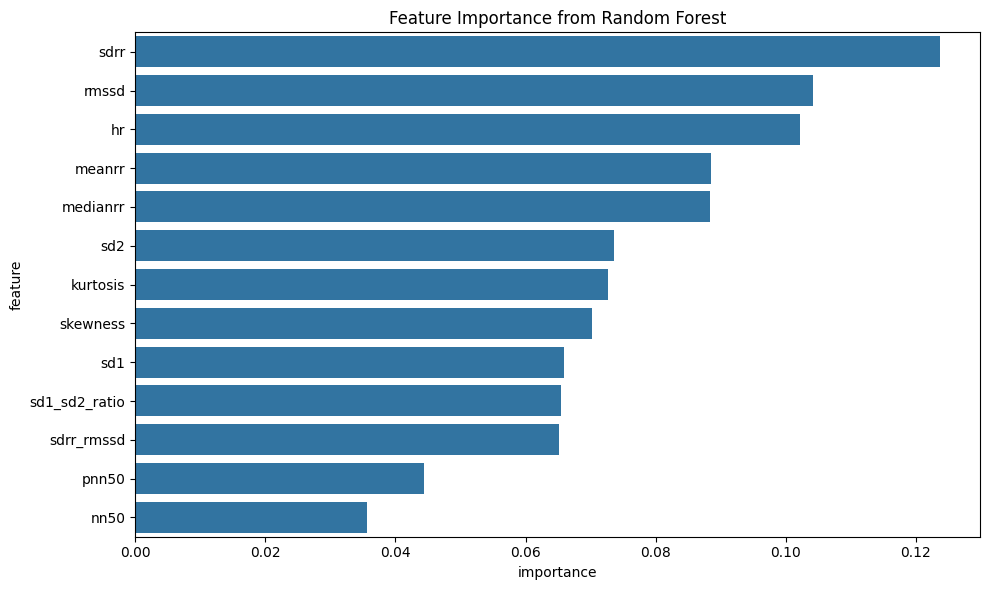

In [7]:
print("\n--- Section 7: Feature Selection ---")
# Train a preliminary Random Forest model on the *scaled training data*.

# Train a Random Forest to get feature importances
print("Running preliminary Random Forest for feature importance...")
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_selector.fit(X_train_scaled, y_train)

# Get feature importances
importances = rf_selector.feature_importances_
feature_names = X_train_scaled.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

print("Feature Importances:")
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance from Random Forest')
plt.tight_layout()
# plt.show() # Uncomment to display plot during script execution

# --- Feature Selection Strategy ---
# Strategy 1: Select features above a certain threshold (e.g., mean importance)
# importance_threshold = feature_importance_df['importance'].mean()
# selected_features = feature_importance_df[feature_importance_df['importance'] > importance_threshold]['feature'].tolist()

# Strategy 2: Select the top N features (e.g., top 10)
N_TOP_FEATURES = 10
selected_features = feature_importance_df.head(N_TOP_FEATURES)['feature'].tolist()

print(f"\nSelected top {len(selected_features)} features:")
print(selected_features)

# Apply selection to the scaled train and test sets
X_train_selected = X_train_scaled[selected_features]
X_test_selected = X_test_scaled[selected_features]

print(f"\nShape after feature selection:")
print(f"Training set: {X_train_selected.shape}")
print(f"Testing set: {X_test_selected.shape}")

## 8. Class Balancing (SMOTE)


--- Section 8: Class Balancing (SMOTE) ---
Class distribution before SMOTE (Training Data):
3    84
4    61
6    32
5    26
1    24
2    24
0    20
7    13
Name: count, dtype: int64
Using k_neighbors=5 for SMOTE

Class distribution after SMOTE (Training Data):
3    84
7    84
4    84
6    84
2    84
5    84
0    84
1    84
Name: count, dtype: int64

Final training data shape: (672, 10)
Final testing data shape: (122, 10)


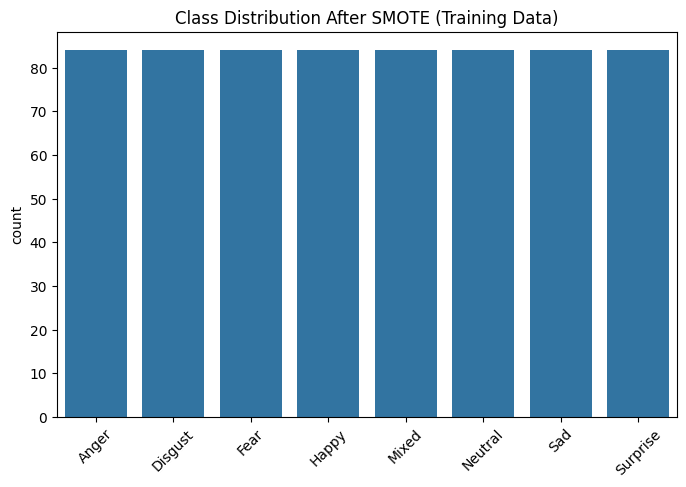

In [8]:
print("\n--- Section 8: Class Balancing (SMOTE) ---")
# Apply SMOTE *only* to the *selected training data*.

print("Class distribution before SMOTE (Training Data):")
print(pd.Series(y_train).value_counts())

# Initialize SMOTE
# 'k_neighbors' should be less than the smallest class size. Adjust if needed.
min_class_size = pd.Series(y_train).value_counts().min()
n_neighbors = min(5, min_class_size - 1) if min_class_size > 1 else 1
print(f"Using k_neighbors={n_neighbors} for SMOTE")

if n_neighbors < 1:
    print("Warning: Smallest class size is too small for SMOTE. Skipping balancing.")
    X_train_final = X_train_selected
    y_train_final = y_train
else:
    try:
        smote = SMOTE(random_state=42, k_neighbors=n_neighbors)
        X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train)

        print("\nClass distribution after SMOTE (Training Data):")
        print(pd.Series(y_train_smote).value_counts())

        # Plot class distribution after SMOTE
        plt.figure(figsize=(8, 5))
        sns.countplot(x=y_train_smote)
        plt.title('Class Distribution After SMOTE (Training Data)')
        # Use label encoder to show original emotion names on the plot
        plt.xticks(ticks=le.transform(le.classes_), labels=le.classes_, rotation=45)
        # plt.show() # Uncomment to display plot

        X_train_final = X_train_smote
        y_train_final = y_train_smote

    except ValueError as e:
        print(f"Error during SMOTE: {e}. Using original training data.")
        X_train_final = X_train_selected
        y_train_final = y_train

# The test set remains unchanged (unbalanced and selected features)
X_test_final = X_test_selected
y_test_final = y_test

print(f"\nFinal training data shape: {X_train_final.shape}")
print(f"Final testing data shape: {X_test_final.shape}")

## 9. Feature Fusion (Conceptual Note)

In [9]:
# Feature fusion involves creating new features by combining existing ones.
# While not explicitly implemented here, the HRV features themselves are derived
# ('fused') from the raw time-series data. Further fusion could be explored.

## 10. Standard Machine Learning Classification

In [10]:
print("\n--- Section 10: Standard Machine Learning Classification ---")
# Train and evaluate classifiers on processed data.

# Define classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVC": SVC(probability=True, random_state=42), # probability=True needed for some metrics
    "KNN": KNeighborsClassifier(n_neighbors=5), # Can tune n_neighbors
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss') # mlogloss for multiclass
}

# Train and evaluate each classifier
results = {}

for name, clf in classifiers.items():
    print(f"\n--- Training {name} ---")
    start_time = datetime.now()

    # Train the model
    clf.fit(X_train_final, y_train_final)

    # Make predictions on the test set
    y_pred = clf.predict(X_test_final)

    # Evaluate
    accuracy = metrics.accuracy_score(y_test_final, y_pred)
    report = classification_report(y_test_final, y_pred, target_names=le.classes_, output_dict=True, zero_division=0)
    report_str = classification_report(y_test_final, y_pred, target_names=le.classes_, zero_division=0)

    end_time = datetime.now()
    print(f"Training and Prediction Duration: {end_time - start_time}")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report_str)
    print("-------------------------")

    results[name] = {
        'model': clf,
        'accuracy': accuracy,
        'report_dict': report,
        'report_str': report_str
    }

# Display results summary
results_summary = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [res['accuracy'] for res in results.values()],
    'Weighted F1-Score': [res['report_dict']['weighted avg']['f1-score'] for res in results.values()]
})
results_summary = results_summary.sort_values(by='Weighted F1-Score', ascending=False)

print("\n=== Model Performance Summary ===")
print(results_summary)


--- Section 10: Standard Machine Learning Classification ---

--- Training Logistic Regression ---
Training and Prediction Duration: 0:00:00.029769
Accuracy: 0.1393
Classification Report:
              precision    recall  f1-score   support

       Anger       0.20      0.25      0.22         8
     Disgust       0.50      0.10      0.17        10
        Fear       0.10      0.64      0.17        11
       Happy       0.00      0.00      0.00        36
       Mixed       0.00      0.00      0.00        27
     Neutral       0.27      0.36      0.31        11
         Sad       0.22      0.14      0.17        14
    Surprise       0.11      0.20      0.14         5

    accuracy                           0.14       122
   macro avg       0.18      0.21      0.15       122
weighted avg       0.12      0.14      0.10       122

-------------------------

--- Training SVC ---
Training and Prediction Duration: 0:00:00.095029
Accuracy: 0.1311
Classification Report:
              precision

## 11. Analysis of Best Model (Example)


--- Section 11: Analysis of Best Model ---

=== Detailed Results for Best Model: Random Forest ===
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00         8
     Disgust       0.33      0.20      0.25        10
        Fear       0.10      0.64      0.18        11
       Happy       0.30      0.08      0.13        36
       Mixed       0.50      0.11      0.18        27
     Neutral       0.31      0.45      0.37        11
         Sad       0.33      0.21      0.26        14
    Surprise       0.00      0.00      0.00         5

    accuracy                           0.19       122
   macro avg       0.24      0.21      0.17       122
weighted avg       0.30      0.19      0.18       122



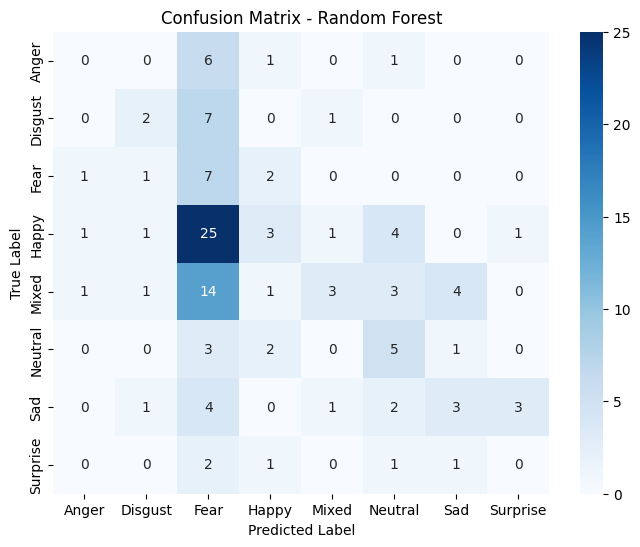

In [11]:
print("\n--- Section 11: Analysis of Best Model ---")

if not results_summary.empty:
    best_model_name = results_summary.iloc[0]['Model']
    best_model_results = results[best_model_name]
    best_model = best_model_results['model']

    print(f"\n=== Detailed Results for Best Model: {best_model_name} ===")

    # Print classification report again for clarity
    print(best_model_results['report_str'])

    # Plot Confusion Matrix
    y_pred_best = best_model.predict(X_test_final)
    cm = confusion_matrix(y_test_final, y_pred_best)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix - {best_model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    # plt.show() # Uncomment to display plot

else:
    print("No results available to determine the best model.")

## 12. Optional: Hyperparameter Tuning

In [12]:
print("\n--- Section 12: Optional Hyperparameter Tuning ---")
# Example using RandomizedSearchCV for Random Forest

# Define parameter distribution
param_dist_rf = {
    'n_estimators': [100, 200, 300, 500, 700],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None] # Changed from 'auto' to 'sqrt'
    # 'bootstrap': [True, False] # Usually True for RF
}

# Setup Stratified K-Fold for cross-validation during tuning
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Setup Randomized Search
rf_tuned = RandomForestClassifier(random_state=42, n_jobs=-1)
random_search_rf = RandomizedSearchCV(
    estimator=rf_tuned,
    param_distributions=param_dist_rf,
    n_iter=20, # Number of parameter settings that are sampled
    cv=cv_strategy,
    verbose=1, # Set to 1 or higher for more output
    random_state=42,
    n_jobs=-1, # Use all available cores
    scoring='accuracy' # Or 'f1_weighted'
)

print("\n--- Starting Hyperparameter Tuning for Random Forest ---")
start_time_tuning = datetime.now()

# Fit Randomized Search to the balanced, selected training data
# Check if training data is available before fitting
if X_train_final is not None and y_train_final is not None and len(X_train_final) > 0:
    random_search_rf.fit(X_train_final, y_train_final)

    end_time_tuning = datetime.now()
    print(f"Tuning Duration: {end_time_tuning - start_time_tuning}")

    print("\nBest Parameters found:")
    print(random_search_rf.best_params_)

    print("\nBest cross-validation score (Accuracy):")
    print(random_search_rf.best_score_)

    # Evaluate the best model found by Randomized Search on the test set
    best_rf_tuned = random_search_rf.best_estimator_
    y_pred_tuned = best_rf_tuned.predict(X_test_final)

    print("\n--- Performance of Tuned Random Forest on Test Set ---")
    report_tuned_str = classification_report(y_test_final, y_pred_tuned, target_names=le.classes_, zero_division=0)
    print(report_tuned_str)

    # Add tuned model results to comparison if desired
    tuned_accuracy = metrics.accuracy_score(y_test_final, y_pred_tuned)
    tuned_report_dict = classification_report(y_test_final, y_pred_tuned, target_names=le.classes_, output_dict=True, zero_division=0)
    results['Random Forest Tuned'] = {
        'model': best_rf_tuned,
        'accuracy': tuned_accuracy,
        'report_dict': tuned_report_dict,
        'report_str': report_tuned_str
    }

    # Update results summary
    results_summary = pd.DataFrame({
        'Model': list(results.keys()),
        'Accuracy': [res['accuracy'] for res in results.values()],
        'Weighted F1-Score': [res['report_dict']['weighted avg']['f1-score'] for res in results.values()]
    })
    results_summary = results_summary.sort_values(by='Weighted F1-Score', ascending=False)
    print("\n=== Updated Model Performance Summary (including Tuned RF) ===")
    print(results_summary)

else:
    print("Skipping hyperparameter tuning as training data is empty or None.")


--- Section 12: Optional Hyperparameter Tuning ---

--- Starting Hyperparameter Tuning for Random Forest ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tuning Duration: 0:00:08.467922

Best Parameters found:
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 10}

Best cross-validation score (Accuracy):
0.4032835820895523

--- Performance of Tuned Random Forest on Test Set ---
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00         8
     Disgust       0.33      0.20      0.25        10
        Fear       0.10      0.64      0.17        11
       Happy       0.14      0.03      0.05        36
       Mixed       0.29      0.07      0.12        27
     Neutral       0.31      0.45      0.37        11
         Sad       0.25      0.14      0.18        14
    Surprise       0.00      0.00      0.00         5

    accuracy                           0.16       122
   mac